## Introduction
Based off of Colab Notebooks by [Kris Ograbek](https://colab.research.google.com/drive/1SQmK0GYz34RGVlOnL5YMkdm7hXD6OjQT?usp=sharing#scrollTo=6lD_oW1uavGp), [Meta](https://colab.research.google.com/drive/1X1z9Q6domMKl2CnEM0QGHNwidLfR4dW2?usp=sharing#scrollTo=THqfvzHIjSK9), and Lara Martin (Intro to NLP class).

This is the companion notebook to [HW 3](https://laramartin.net/interactive-fiction-class/homeworks/plan-and-write/plan-and-write.html) for CMSC 491/691 Interactive Fiction and Text Generation.

### Getting access to the model

To load Llama-2, we first need to authenticate yourself on Hugging Face. This ensures that we have permission to fetch the model.

1. Gain access to the model on Hugging Face: [Link](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf).
2. Use the Hugging Face CLI to login below and verify your authentication status. If you don't already have one, you will need to generate a "read" User Access Token.
3. You will need to be using a GPU to run the model. Select `Runtime -> Change runtime type` in Colab to change this.



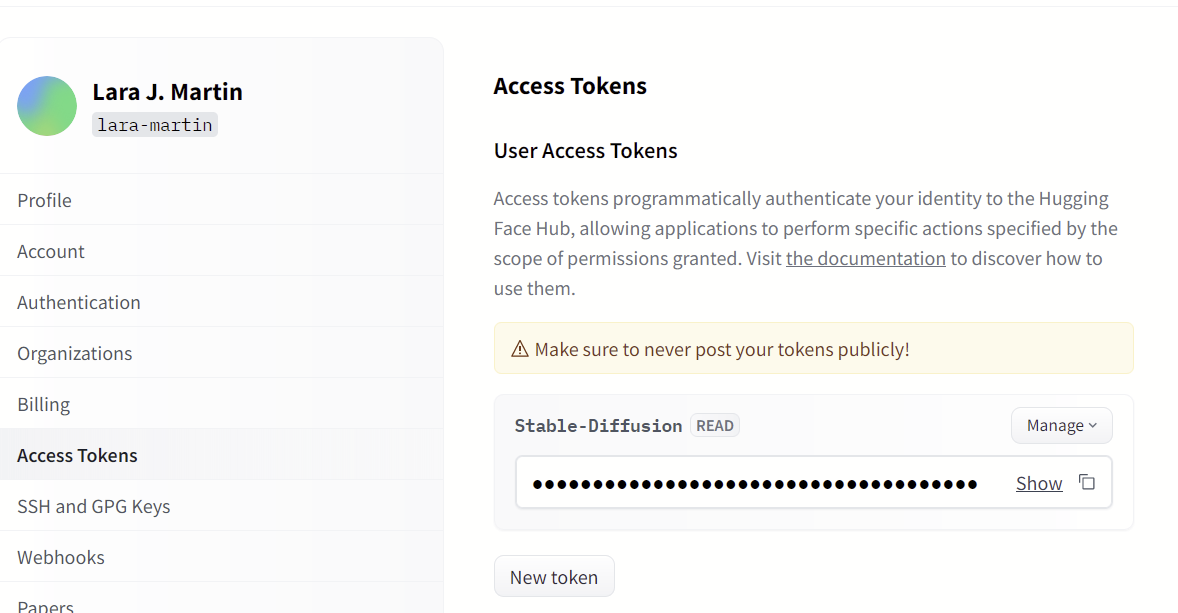

In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [2]:
!huggingface-cli whoami

lara-martin
orgs:  UMBC


## Installations
 Install the necessary libraries.

In [4]:
!pip install transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 3.9 MB/s eta 0:00:00


## Getting the Data

This is the original data from the [Plan-and-Write paper](https://ojs.aaai.org/index.php/AAAI/article/view/4726). It contains the 5-sentence stories, their extracted keywords, and their corresponding titles. We will only be looking at 20 stories from this dataset.

I have written functions below to extract the relevant data.
* `load_data` will return a list of all of the data in the file.
* `get_story` will return a list of the sentences in the story.
* `get_title` will return the title of a story from a given line.
* `get_keywords` will return the keywords of a story from a given line.

In [1]:
!wget https://bitbucket.org/VioletPeng/language-model/raw/b674095aa60a3e1bd14dadc12471968e583acf1d/rocstory_plan_write/ROCStories_all_merge_tokenize.titlesepkeysepstory

--2024-10-17 00:08:39--  https://bitbucket.org/VioletPeng/language-model/raw/b674095aa60a3e1bd14dadc12471968e583acf1d/rocstory_plan_write/ROCStories_all_merge_tokenize.titlesepkeysepstory
Resolving bitbucket.org (bitbucket.org)... 104.192.142.26, 104.192.142.25, 104.192.142.24, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.142.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31289836 (30M) [text/plain]
Saving to: ‘ROCStories_all_merge_tokenize.titlesepkeysepstory’

ROCStories_all_merg 100%[===================>]  29.84M  14.2MB/s    in 2.1s    

2024-10-17 00:08:43 (14.2 MB/s) - ‘ROCStories_all_merge_tokenize.titlesepkeysepstory’ saved [31289836/31289836]



In [6]:
#fixing my car <EOT> car turn tested alternator bad <EOL> </s> i went to start my car last friday . </s> my car would n't turn over . </s> i took my alternator off to be tested . </s> the parts store said that it was bad . </s> i replaced my alternator with a new one .


def load_data():
  stories = []
  with open('ROCStories_all_merge_tokenize.titlesepkeysepstory','r') as in_file:
    reader = in_file.readlines()
    for line in reader[1:21]:
      stories.append(line.strip())
  return stories

def get_title(line):
  title, _ = line.split(" <EOT> ")
  return title

def combine_words(sentence):
  s = sentence.strip().replace(" .",".").replace(" n't","n't").replace(" '","'").replace(" ,",",").replace(" i "," I ").replace(" !","!")
  return s.upper()[0]+s[1:]

def get_story(line):
  _, story = line.split(" <EOL> ")
  sentences = [combine_words(sentence) for sentence in story.split("</s>") if sentence]
  return sentences


def get_keywords(line):
  _, rest = line.split(" <EOT> ")
  keywords,_ = rest.split(" <EOL> ")
  keywords = keywords.split()
  return keywords

raw_stories = load_data()

In [6]:
# Here are some print statements to show what each of these looks like
print(get_keywords(raw_stories[0]))
print(get_title(raw_stories[0]))
print(get_story(raw_stories[0]))

['learned', 'sister', 'crashed', 'hill', 'nervous']
the bike accident
['Carrie had just learned how to ride a bike.', "She didn't have a bike of her own.", "Carrie would sneak rides on her sister's bike.", 'She got nervous on a hill and crashed into a wall.', 'The bike frame bent and carrie got a deep gash on her leg.']


## Setup the model

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_name = "meta-llama/Llama-2-7b-chat-hf"

This next step will take a couple minutes to download the model.

In [8]:
# From the Llama-2 Chat Tutorial
# https://colab.research.google.com/drive/1X1z9Q6domMKl2CnEM0QGHNwidLfR4dW2?usp=sharing#scrollTo=THqfvzHIjSK9

quantization_config = BitsAndBytesConfig(load_in_4bit=True) # https://discuss.huggingface.co/t/correct-usage-of-bitsandbytesconfig/33809
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", quantization_config=quantization_config)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, use_auth_token=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Generating Stories

Now you will use Llama-2 to generate stories. You can change the `prompt` variable to provide the model with different input.

Follow the instructions on [the homework page](https://laramartin.net/interactive-fiction-class/homeworks/plan-and-write/plan-and-write.html) to know what you should be generating.

In [15]:
uncontrolled_stories = []
controlled_stories = []

In [10]:
for line in raw_stories:
  # TODO: Change the prompt. Tip: Be sure to call get_title(line)
  prompt = 'You are a helpful assistant who recommends TV shows. What are some recommendations for someone who liked "Breaking Bad"?\n1.'
  model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")
  output = model.generate(**model_inputs)
  decoded_text = tokenizer.decode(output[0], skip_special_tokens=True)
  uncontrolled_stories.append(decoded_text)


You are a helpful assistant who recommends TV shows. What are some recommendations for someone who liked "Breaking Bad"?
1. "Narcos" - This Netflix original series tells the true story of the rise and fall of drug kingpin Pablo Escobar and the DEA agents who hunted him down.
2. "The Sopranos" - This classic HBO series follows the life of Tony Soprano, a New Jersey mob boss who seeks therapy to deal with his personal and professional problems.
3. "Peaky Blinders" - This BBC series is set in post-World War I England and follows a gangster family as they navigate the criminal underworld and the changing political landscape.
4. "Better Call Saul" - This AMC series is a prequel to "Breaking Bad" and follows the story of small-time lawyer Jimmy McGill as he transforms into the morally ambiguous lawyer Saul Goodman.
5. "Ozark" - This Netflix series follows a financial advisor who is forced to launder money for a drug cartel and relocates his family to the Missouri Ozarks.
6. "Sons of Anarchy"

In [ ]:
for line in raw_stories:
  # TODO: Change the prompt. Tip: Be sure to call get_title(line) AND get_keywords(line)
  prompt = 'You are a helpful assistant who recommends TV shows. What are some recommendations for someone who liked "Breaking Bad"?\n1.'
  model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")
  output = model.generate(**model_inputs)
  decoded_text = tokenizer.decode(output[0], skip_special_tokens=True)
  controlled_stories.append(decoded_text)

### Known Problem

After 3-4 prompts, the model might stop giving responses, only outputing the user prompt.
To keep talking to the model, you'll need to restart the notebook: `Runtime -> Restart Runtime`

# Evaluation

Now you will compare your the unguided generated stories to the original stories and compare the guided generated stories to the original stories using the following libraries:

BLEU -
[https://www.nltk.org/api/nltk.translate.bleu_score.html](https://www.nltk.org/api/nltk.translate.bleu_score.html)
- Run *modified n-gram precision* with unigrams and bigrams

ROUGE -
[https://pypi.org/project/rouge-score/](https://pypi.org/project/rouge-score/)
- Run unigrams, bigrams, and ROUGE-L




In [3]:
import statistics
def BLEU(hypothesis, target, n=1):
  # TODO: calculate BLEU by comparing the generated story (hypothesis)
  # to the original story (target) looking at n-grams for multiple n's
  # return the average score across the sentences of the stories
  return

def ROUGE(hypothesis, target, n="L"):
  # TODO: calculate ROUGE by comparing the generated story (hypothesis)
  # to the original story (target) looking at n-grams for multiple n's AND ROUGE-L
  # return the average score across the sentences of the stories
  return


In [ ]:
avg_BLEU_1_controlled = []
avg_BLEU_2_controlled = []
avg_BLEU_1_uncontrolled = []
avg_BLEU_2_uncontrolled = []

avg_ROUGE_1_controlled = []
avg_ROUGE_2_controlled = []
avg_ROUGE_L_controlled = []
avg_ROUGE_1_uncontrolled = []
avg_ROUGE_2_uncontrolled = []
avg_ROUGE_L_uncontrolled = []


# Iterate through BLEU and ROUGE for all 20 story prompts & average the scores
for i, line in enumerate(raw_stories):
  print(get_story(line))
  print(controlled_stories[i])
  avg_BLEU_1_controlled.append(BLEU(get_story(line),controlled_stories[i], 1))
  avg_BLEU_2_controlled.append(BLEU(get_story(line),controlled_stories[i], 2))
  avg_BLEU_1_uncontrolled.append(BLEU(get_story(line),uncontrolled_stories[i], 1))
  avg_BLEU_2_uncontrolled.append(BLEU(get_story(line),uncontrolled_stories[i], 2))

  avg_ROUGE_1_controlled.append(ROUGE(get_story(line),controlled_stories[i], "1"))
  avg_ROUGE_2_controlled.append(ROUGE(get_story(line),controlled_stories[i], "2"))
  avg_ROUGE_L_controlled.append(ROUGE(get_story(line),controlled_stories[i], "L"))
  avg_ROUGE_1_uncontrolled.append(ROUGE(get_story(line),uncontrolled_stories[i], "1"))
  avg_ROUGE_2_uncontrolled.append(ROUGE(get_story(line),uncontrolled_stories[i], "2"))
  avg_ROUGE_L_uncontrolled.append(ROUGE(get_story(line),uncontrolled_stories[i], "L"))


print("\t\t| BLEU-1\t| BLEU-2\t| ROUGE-1\t| ROUGE-2\t| ROUGE-L\t|")
print("Controlled\t| {}\t\t| {}\t\t| {}\t\t| {}\t\t| {}\t\t|".format(statistics.mean(avg_BLEU_1_controlled),statistics.mean(avg_BLEU_2_controlled),statistics.mean(avg_ROUGE_1_controlled),statistics.mean(avg_ROUGE_2_controlled),statistics.mean(avg_ROUGE_L_controlled)))
print("Uncontrolled\t| {}\t\t| {}\t\t| {}\t\t| {}\t\t| {}\t\t|".format(statistics.mean(avg_BLEU_1_uncontrolled),statistics.mean(avg_BLEU_2_uncontrolled),statistics.mean(avg_ROUGE_1_uncontrolled),statistics.mean(avg_ROUGE_2_uncontrolled),statistics.mean(avg_ROUGE_L_uncontrolled)))